# Chainerのテスト
* http://qiita.com/kenmatsu4/items/7b8d24d4c5144a686412
* ↑を参考にする


## MNIST手書き文字の認識アプリを作ってみる

* 「モデル学習」用のアプリ。学習済みのモデルを使って「文字認識」するアプリの２段構成
* このipythonでは、「モデル学習」の部分だけ


### 必要なライブラリのインポート

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import six

import chainer
from chainer import computational_graph as c
from chainer import cuda
import chainer.functions as F
from chainer import optimizers

import data

import argparse

from chainer import Variable, FunctionSet, optimizers
from sklearn.datasets import fetch_mldata


In [3]:
%matplotlib inline

### パラメータの設定

In [4]:
##### 各種パラメータの定義、設定
# 確率的勾配降下法で学習させる際の１回分のバッチサイズ
batchsize = 100
# 学習の繰り返し回数
n_epoch   = 20
# 中間層の数
n_units   = 1000

### 手書き数字データのダウンロード
* data パッケージを使ってデータを取得する
* 実行ディレクトリ上に、以下ファイルができる
 * train-labels-idx1-ubyte.gz
 * train-images-idx3-ubyte.gz
 * t10k-images-idx3-ubyte.gz
 * t10k-labels-idx1-ubyte.gz
 * mnist.pkl
* 結構時間がかかる

In [5]:
##### MNISTの手書き数字データのダウンロード
print('load MNIST dataset')
mnist = data.load_mnist_data()
mnist['data'] = mnist['data'].astype(np.float32)
# 0-1に変換
mnist['data'] /= 255
mnist['target'] = mnist['target'].astype(np.int32)

load MNIST dataset
Done
Done
Done
Done
Converting training data...
Done
Converting test data...
Done
Save output...
Done
Convert completed


* DLしてきたデータを眺めてみる
 * 28*28ピクセルの画像データの濃淡を0~1で表現しているので、784次元のベクトルで表現される

In [8]:
print len(mnist['data'][5])
print mnist['data'][5]

784
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        

### 手書きデータを描画してみる

In [30]:
# 手書き数字データを描画する関数
def draw_digit(data):
    size = 28
    plt.figure(figsize=(2, 2))

    X, Y = np.meshgrid(range(size),range(size))
    Z = data.reshape(size,size)   # convert from vector to 28x28 matrix
    Z = Z[::-1,:]             # flip vertical
    plt.xlim(0,27)
    plt.ylim(0,27)
    plt.pcolor(X, Y, Z)
    plt.gray()
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")

    plt.show()

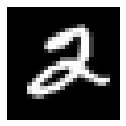

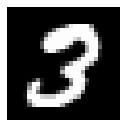

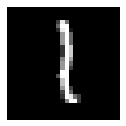

In [32]:
# 3つくらい描いてみる
draw_digit(mnist['data'][5])
draw_digit(mnist['data'][12345])
draw_digit(mnist['data'][33456])

## 学習させる
### (前処理)学習用と評価用にデータを分ける

In [25]:
# 学習用データを N個、検証用データを残りの個数と設定
N = 60000
x_train, x_test = np.split(mnist['data'],   [N])
y_train, y_test = np.split(mnist['target'], [N])
N_test = y_test.size

### モデルの定義
* Prepare multi-layer perceptron model
* 普通の3層パーセプトロンモデルでモデルを作る
* 入力(l1)：28×28の画像なので784次元
* 出力(l3)：数字なので10次元

In [26]:
model = chainer.FunctionSet(l1=F.Linear(784, n_units),
                            l2=F.Linear(n_units, n_units),
                            l3=F.Linear(n_units, 10))

### 順伝播の構造定義

In [27]:
def forward(x_data, y_data, train=True):
    # Neural net architecture
    x, t = chainer.Variable(x_data), chainer.Variable(y_data)
    h1 = F.dropout(F.relu(model.l1(x)),  train=train)
    h2 = F.dropout(F.relu(model.l2(h1)), train=train)
    y = model.l3(h2)
    # 多クラス分類なので誤差関数としてソフトマックス関数の
    # 交差エントロピー関数を用いて、誤差を導出
    return F.softmax_cross_entropy(y, t), F.accuracy(y, t)

### Optimizerの設定

In [28]:
# Setup optimizer
optimizer = optimizers.Adam()
optimizer.setup(model)

### 学習の実行
* http://qiita.com/kenmatsu4/items/7b8d24d4c5144a686412
 * ここを参考に
* GPGPU無しでけっこう時間かかるので注意

epoch 1
train mean loss=0.277653188289, accuracy=0.91536666736
test  mean loss=0.108144650948, accuracy=0.96560000658
epoch 2
train mean loss=0.13641287334, accuracy=0.958266670704
test  mean loss=0.0899389906297, accuracy=0.969600005746


[]

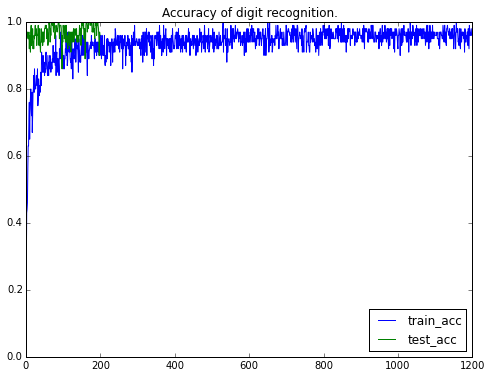

In [29]:
train_loss = []
train_acc  = []
test_loss = []
test_acc  = []

# Learning loop
for epoch in xrange(1, n_epoch+1):
    print 'epoch', epoch
    # training 
    ## N個の学習データの順番をランダムに並び替える
    perm = np.random.permutation(N)
    sum_accuracy = 0
    sum_loss = 0
    # 0〜Nまでのデータをバッチサイズごとに学習
    for i in xrange(0, N, batchsize):
        # バッチサイズ分のデータを取り出す
        x_batch = x_train[perm[i:i+batchsize]]
        y_batch = y_train[perm[i:i+batchsize]]
        # 勾配を初期化
        optimizer.zero_grads()
        # 順伝播させて誤差と精度を算出
        loss, acc = forward(x_batch, y_batch)
        # 誤差逆伝播で勾配を計算
        loss.backward()
        optimizer.update()
        # 誤差率, 精度をまとめておく
        train_loss.append(loss.data)
        train_acc.append(acc.data)
        sum_loss     += float((loss.data)) * batchsize
        sum_accuracy += float((acc.data)) * batchsize
    # 訓練データの誤差と、正解精度を標準出力
    print 'train mean loss={}, accuracy={}'.format(sum_loss/N, sum_accuracy/N)
    # テストデータで誤差と、正解精度を算出し汎化性能を確認
    sum_accuracy = 0
    sum_loss     = 0
    for i in xrange(0, N_test, batchsize):
        # バッチサイズ分のデータを取り出す
        x_batch = x_test[i:i+batchsize]
        y_batch = y_test[i:i+batchsize]
        # 順伝播させて誤差と精度を算出
        loss, acc = forward(x_batch, y_batch, train=False)
        # テストデータに対する誤差率, 精度をまとめておく
        test_loss.append(loss.data)
        test_acc.append(acc.data)
        sum_loss     += float((loss.data)) * batchsize
        sum_accuracy += float((acc.data)) * batchsize
    # テストデータでの誤差と、正解精度を標準出力
    print 'test  mean loss={}, accuracy={}'.format(sum_loss/N_test, sum_accuracy/N_test)
print("Finish : Training Process")

### 学習結果の確認 : 学習過程を確認
* 訓練の過程で精度が変化していくかを確認してみる

[]

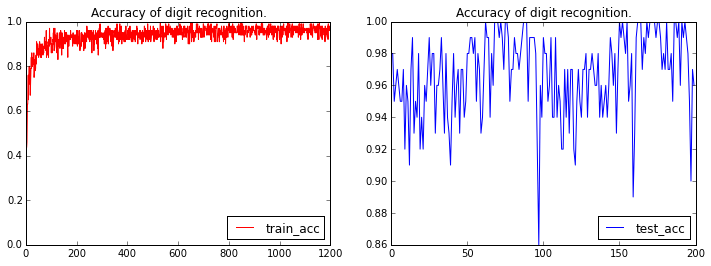

In [36]:
# 精度をグラフ描画する
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(len(train_acc)), train_acc, color="#FF0000")
plt.legend(["train_acc"],loc=4)
plt.title("Accuracy of digit recognition.")
plt.subplot(1,2,2)
plt.plot(range(len(test_acc)), test_acc, color="#0000FF")
plt.legend(["test_acc"],loc=4)
plt.title("Accuracy of digit recognition.")
plt.plot()

### 学習結果の確認 : NNの第１層のパラメータを見てみる
* NNの各ノードがどのような特徴に反応するのかを見てみる
* 入力層は784次元（28×28ピクセル）、それを第１層のノード(1000)に入力する(モデルの定義により)
* 1000ノードのうち、ランダムに100ノードのパラメータを可視化
* 出力結果を眺めると、直線に反応するノードとか、丸に反応するノードとかが見えてきて面白い

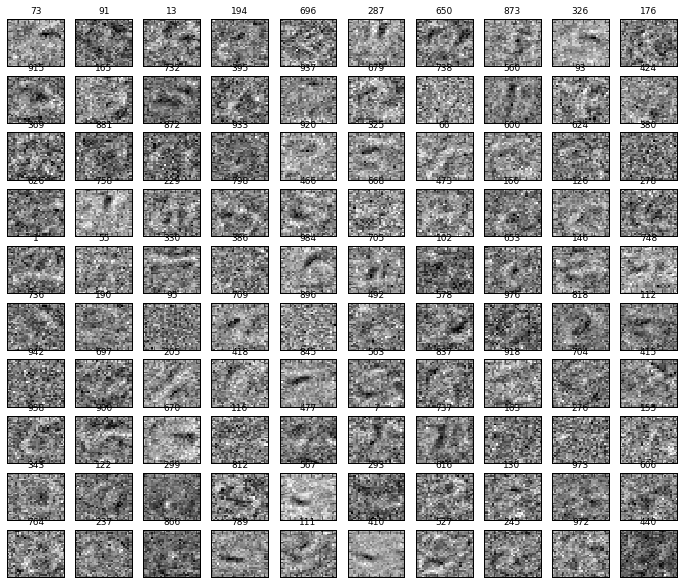

In [38]:
def draw_digit2(data, n, i):
    size = 28
    plt.subplot(10, 10, n)
    Z = data.reshape(size,size)   # convert from vector to 28x28 matrix
    Z = Z[::-1,:]             # flip vertical
    plt.xlim(0,27)
    plt.ylim(0,27)
    plt.pcolor(Z)
    plt.title("%d"%i, size=9)
    plt.gray()
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")

plt.figure(figsize=(12,10))
cnt = 1
for i in np.random.permutation(1000)[:100]:
    draw_digit2(model.l1.W[i], cnt, i)
    cnt += 1
plt.show()

### モデルのダンプ
* 学習済みのモデルを別のアプリで利用するために、モデルをファイルにダンプする
* モデルはpickleパッケージを使ってダンプする
 * GPU使って学習した場合、グラボのメモリにデータを展開するので注意
 * GPUで学習したモデルをCPUのみのマシンで動かす可能性がある場合には、事前にto_cpuコマンドでCPUに展開するように指定しおく必要がある

In [39]:
import pickle

In [40]:
fid = open('test.model', 'wb')
pickle.dump(model, fid)
fid.close()

* 学習に関してはここまでなんだが、以下に文字認識させてみた結果を載せる

## 文字認識の評価
* 文字認識をやらせてみる

### 識別結果の表示用関数

In [42]:
def draw_digit3(data, n, ans, recog):
    size = 28
    plt.subplot(10, 10, n)
    Z = data.reshape(size,size)   # convert from vector to 28x28 matrix
    Z = Z[::-1,:]             # flip vertical
    plt.xlim(0,27)
    plt.ylim(0,27)
    plt.pcolor(Z)
    plt.title("ans=%d, recog=%d"%(ans,recog), size=8)
    plt.gray()
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")

### 文字識別
* 訓練データの中からランダムに100個サンプルしてきて、それを識別させる

<function matplotlib.pyplot.show>

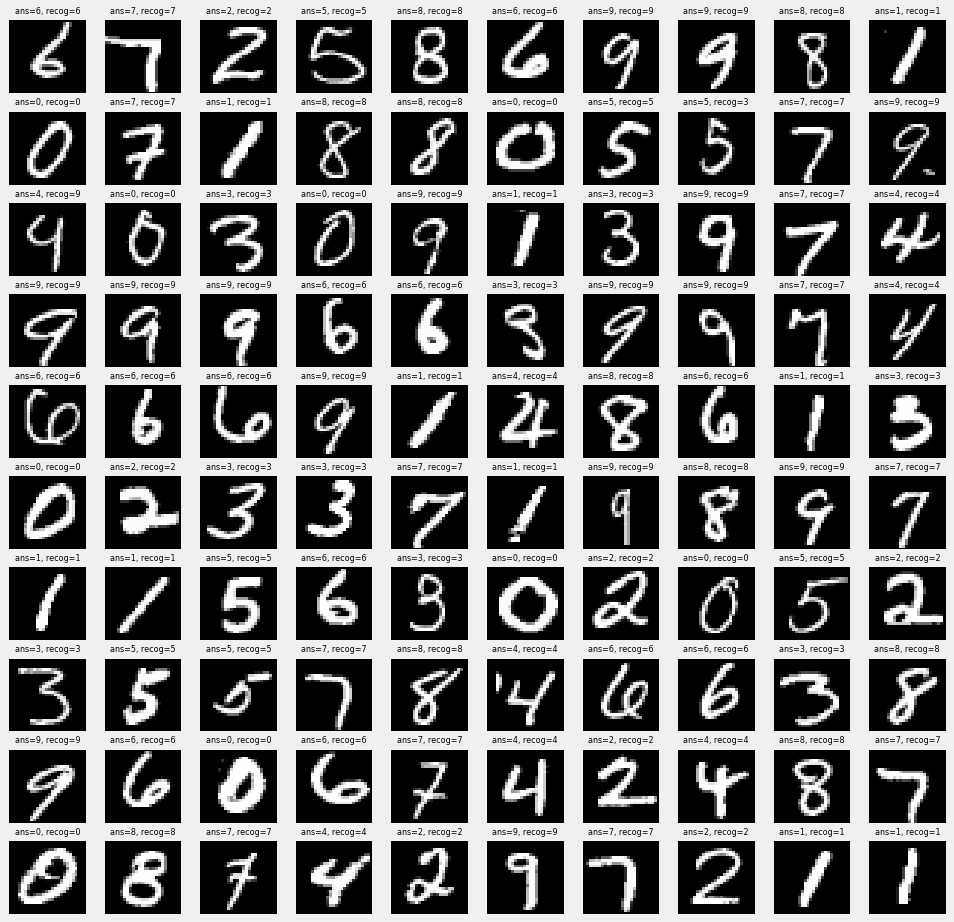

In [43]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15,15))
cnt = 0
for idx in np.random.permutation(N)[:100]:
    xxx = x_train[idx].astype(np.float32)
    h1 = F.dropout(F.relu(model.l1(Variable(xxx.reshape(1,784)))),  train=False)
    h2 = F.dropout(F.relu(model.l2(h1)), train=False)
    y  = model.l3(h2)
    cnt+=1
    draw_digit3(x_train[idx], cnt, y_train[idx], np.argmax(y.data))
plt.show
